# Encoders and decoders

> In this post, we will implement simple autoencoder architecture. This is the summary of lecture "Probabilistic Deep Learning with Tensorflow 2" from Imperial College London.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow_probability, ICL]
- image: images/mnist_reconstruction.png

## Packages

In [3]:
import tensorflow as tf
import tensorflow_probability as tfp

import numpy as np
import matplotlib.pyplot as plt

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

plt.rcParams['figure.figsize'] = (10, 6)

In [4]:
print("Tensorflow Version: ", tf.__version__)
print("Tensorflow Probability Version: ", tfp.__version__)

Tensorflow Version:  2.5.0
Tensorflow Probability Version:  0.13.0


## Overview

### AutoEncoder architecture with tensorflow

AutoEncoder has bottleneck architecture. The width of each of the dense layers is decreasing at first, all the way down to the middle bottleneck layer. The network then starts to widen out again afterwards util the final layer is the same size of shape as the input layer.

```python
from tensorflow.karas.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Reshape

autoencoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='sigmoid'),
    Dnese(64, activation='sigmoid'),
    Dense(2, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(256, activation='sigmoid'),
    Dense(784, activation='sigmoid'),
    Reshape((28, 28))
])

optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0005)
autoencoder.compile(loss='mse', optimizer=optimizer)
autoencoder.fit(X_train, X_train, epochs=20)
```

You can see that this network is trained with X_train, not labels. So it is sort of unsupervised learning.

### Encoder and decoder

We can separate the autoencoder architecture with encoder and decoder.

```python
from tensorflow.keras.models import Models

encoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(2, activation='sigmoid')
])

decoder = Sequential([
    Dense(64, activation='sigmoid', input_shape=(2, )),
    Dense(256, activation='sigmoid'),
    Dense(784, activation='sigmoid'),
    Reshape((28, 28))
])

autoencoder = Model(inputs=encoder.input, outputs=decoder(encoder.output))
autoencoder.compile(loss='mse', optimizer='sgd')
autoencoder.fit(X_train, X_train, epochs=20)
```

### Test for reconstruction

```python

# X_test: (1, 28, 28)
reconstruction = autoencoder(X_test)

X_encoded = encoder(X_test)
z = tf.random.normal([1, 2])
z_decoded = decoder(z) # (1, 28, 28)
```

## Tutorial

We'll use Fashion MNIST for the tutorial.

In [5]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Reshape
import seaborn as sns

In [13]:
# Load Fashion MNIST

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
class_names = np.array(['T-shirt/top', 'Trouser/pants', 'Pullover shirt', 'Dress',
                        'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag','Ankle boot'])

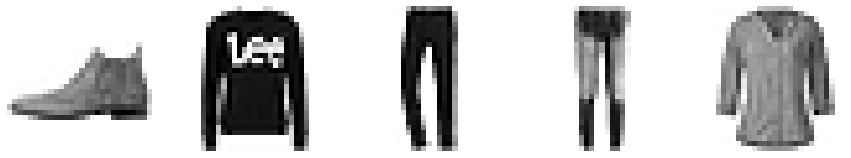

In [14]:
# Display a few examples

n_examples = 1000
example_images = X_test[0:n_examples]
example_labels = y_test[0:n_examples]

f, axs = plt.subplots(1, 5, figsize=(15, 4))
for j in range(len(axs)):
    axs[j].imshow(example_images[j], cmap='binary')
    axs[j].axis('off')
plt.show()

In [8]:
# Define the encoder

encoded_dim = 2

encoder = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(256, activation='sigmoid'),
    Dense(64, activation='sigmoid'),
    Dense(encoded_dim)
])

In [9]:
# Encode examples before training

pretrain_example_encodings = encoder(example_images).numpy()

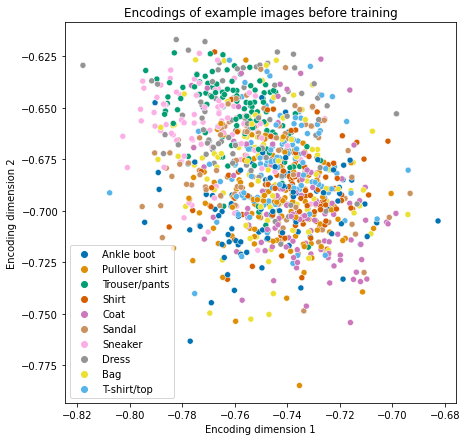

In [11]:
# Plot encoded examples before training 

f, ax = plt.subplots(1, 1, figsize=(7, 7))
sns.scatterplot(x=pretrain_example_encodings[:, 0],
                y=pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=ax,
                palette=sns.color_palette("colorblind", 10));
ax.set_xlabel('Encoding dimension 1'); ax.set_ylabel('Encoding dimension 2')
ax.set_title('Encodings of example images before training');
plt.show()

In [12]:
# Define the decoder

decoder = Sequential([
    Dense(64, activation='sigmoid', input_shape=(encoded_dim,)),
    Dense(256, activation='sigmoid'),
    Dense(28*28, activation='sigmoid'),
    Reshape((28, 28))
])

In [15]:
# Compile and fit the model

autoencoder = Model(inputs=encoder.inputs, outputs=decoder(encoder.output))

# Specify loss - input and output is in [0., 1.], so we can use a binary cross-entropy loss
autoencoder.compile(loss='binary_crossentropy')

# Fit the model - highlight that labels and input are the same
autoencoder.fit(X_train, X_train, epochs=10, batch_size=32)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3969
Epoch 2/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3423
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3343
Epoch 4/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3297
Epoch 5/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3266
Epoch 6/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3245
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3229
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.3218
Epoch 9/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3209
Epoch 10/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.3201


In [16]:
# Compute example encodings after training

posttrain_example_encodings = encoder(example_images).numpy()

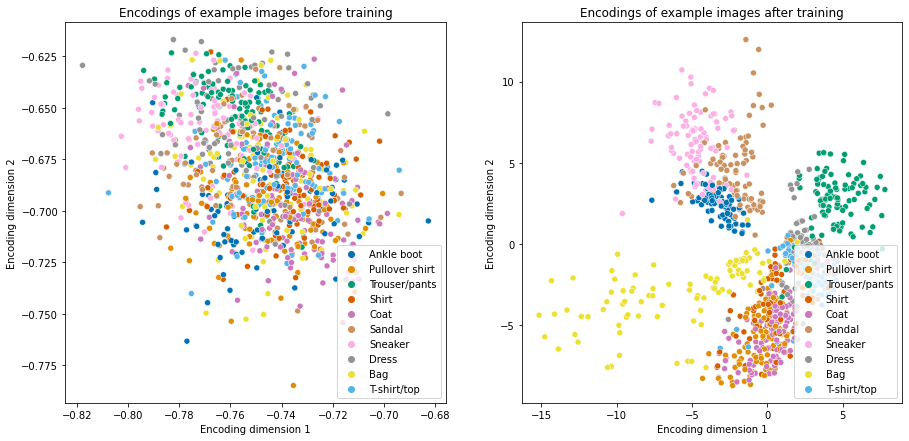

In [18]:
# Compare the example encodings before and after training

f, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
sns.scatterplot(x=pretrain_example_encodings[:, 0],
                y=pretrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[0],
                palette=sns.color_palette("colorblind", 10));
sns.scatterplot(x=posttrain_example_encodings[:, 0],
                y=posttrain_example_encodings[:, 1],
                hue=class_names[example_labels], ax=axs[1],
                palette=sns.color_palette("colorblind", 10));

axs[0].set_title('Encodings of example images before training');
axs[1].set_title('Encodings of example images after training');

for ax in axs: 
    ax.set_xlabel('Encoding dimension 1')
    ax.set_ylabel('Encoding dimension 2')
    ax.legend(loc='lower right')
plt.show()

In [19]:
# Compute the autoencoder's reconstructions

reconstructed_example_images = autoencoder(example_images)

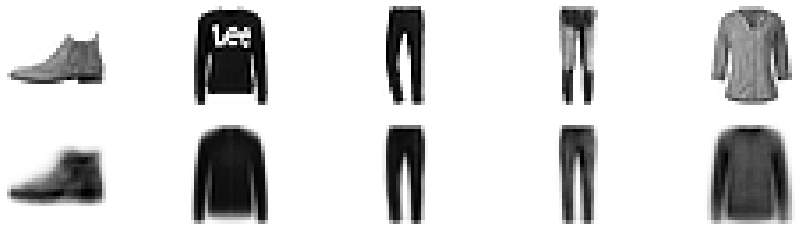

In [20]:
# Evaluate the autoencoder's reconstructions

f, axs = plt.subplots(2, 5, figsize=(15, 4))
for j in range(5):
    axs[0, j].imshow(example_images[j], cmap='binary')
    axs[1, j].imshow(reconstructed_example_images[j].numpy().squeeze(), cmap='binary')
    axs[0, j].axis('off')
    axs[1, j].axis('off')
plt.show()